In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import correlate2d, convolve2d

from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse

from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
from PIL import Image

import cv2
from matplotlib.patches import mlines

In [83]:
imagen = Image.open('images/FMALogo.png')
imagen = np.asarray(imagen).astype(np.uint8)

In [84]:
J = imagen - imagen.min()
J = J / imagen.max()

In [85]:
#sobel filters
#definir matrices
hy = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
hx = hy.T

In [86]:
g = np.array(([1/16, 2/16, 1/16], [2/16, 4/16, 2/16], [1/16, 2/16, 1/16.]))


In [87]:
sz = 1
padJ = np.pad(J, pad_width=sz, mode='symmetric', reflect_type='even')

Gx = correlate2d(padJ, hx, mode='valid')
Gy = correlate2d(padJ, hy, mode='valid')

In [88]:
magnitude = np.sqrt(Gx**2 + Gy**2)
angle = (np.arctan2(-Gy, Gx)*(180/np.pi)) % 180
angle = angle % 180

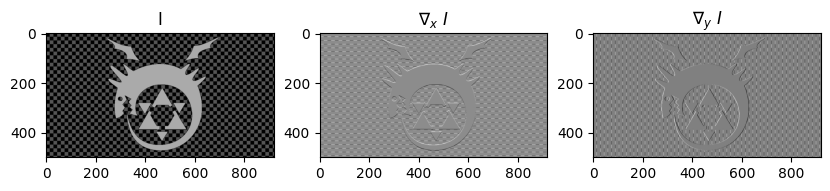

In [89]:
fig = plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.imshow(imagen, cmap='gray')
plt.title('I')
plt.subplot(1,3,2)
plt.imshow(Gx, cmap='gray')
plt.title(r'$\nabla_x \ I$')
plt.subplot(1,3,3)
plt.imshow(Gy, cmap='gray')
plt.title(r'$\nabla_y \ I$')
plt.show()

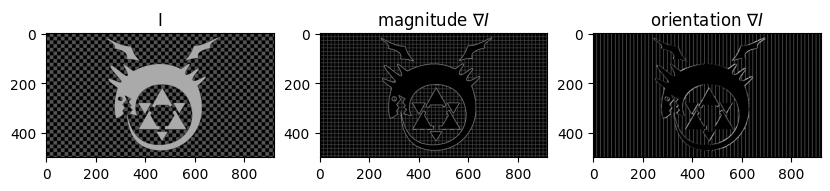

In [90]:
fig = plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.imshow(imagen, cmap='gray')
plt.title('I')
plt.subplot(1,3,2)
plt.imshow(magnitude, cmap='gray')
plt.title(r'magnitude $\nabla I$')
plt.subplot(1,3,3)
plt.imshow(angle, cmap='gray')
plt.title(r'orientation $\nabla I$')
plt.show()

In [91]:
Ixx = Gx**2
Iyy = Gy**2
Ixy = Gx*Gy

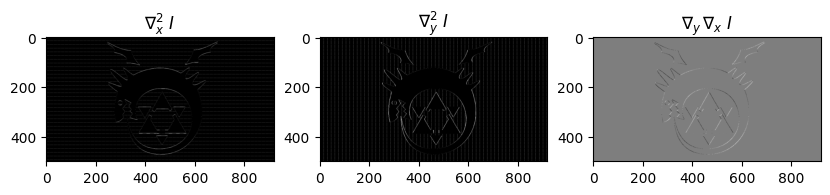

In [92]:
fig = plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.imshow(Ixx, cmap='gray')
plt.title(r'$\nabla_x^2 \ I$')
plt.subplot(1,3,2)
plt.imshow(Iyy, cmap='gray')
plt.title(r'$\nabla_y^2 \ I$')
plt.subplot(1,3,3)
plt.imshow(Ixy, cmap='gray')
plt.title(r'$\nabla_y \, \nabla_x \ I$')
plt.show()

In [93]:
k = 0.05

det = (Ixx*Iyy) - (Ixy*Ixy) 
H   = (Ixx*Iyy) - (Ixy*Ixy) - k*np.square(Ixx + Iyy) 

In [94]:
Hnorm = H - H.min()
Hnorm = Hnorm / Hnorm.max()

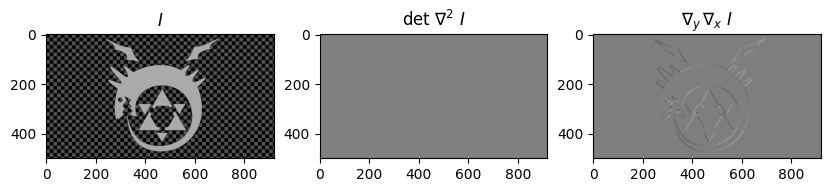

In [95]:
fig = plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.imshow(imagen, cmap='gray')
plt.title(r'$I$')
plt.subplot(1,3,2)
plt.imshow(det, cmap='gray')
plt.title(r'$\det \, \nabla^2 \ I$')
plt.subplot(1,3,3)
plt.imshow(Ixy, cmap='gray')
plt.title(r'$\nabla_y \, \nabla_x \ I$')
plt.show()

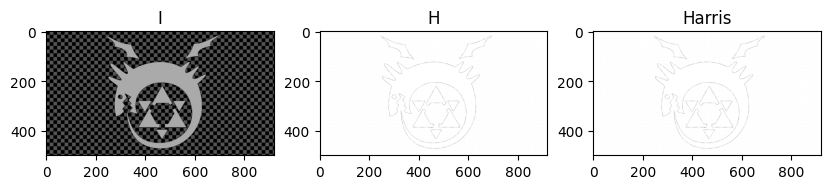

In [96]:
fig = plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.imshow(imagen, cmap='gray')
plt.title('I')
plt.subplot(1,3,2)
plt.imshow(H, cmap='gray')
plt.title('H')
plt.subplot(1,3,3)
plt.imshow(Hnorm, cmap='gray')
plt.title('Harris')
plt.show()

In [97]:
def corner_response(I, k, Sx, Sy, G, sz=1):
    
    # compute first derivatives
    padI = np.pad(I, pad_width=sz, mode='symmetric', reflect_type='even')
    dx  = correlate2d(padI, Sx, mode='valid')
    dy  = correlate2d(padI, Sy, mode='valid')
    
    dxdx = np.pad(dx*dx, pad_width=sz, mode='symmetric', reflect_type='even')
    dydy = np.pad(dy*dy, pad_width=sz, mode='symmetric', reflect_type='even')
    dxdy = np.pad(dx*dy, pad_width=sz, mode='symmetric', reflect_type='even')
    
    Ixx = correlate2d(dxdx, G, mode='valid')
    Iyy = correlate2d(dydy, G, mode='valid')
    Ixy = correlate2d(dxdy, G, mode='valid')
    
    # compute corner response at all pixels
    R = (Ixx*Iyy - (Ixy*Ixy)) - k*((Ixx + Iyy)**2)
    return R

In [98]:
# hyperparameters
k = 0.08
thresh = 0.9

In [99]:
response = corner_response(J, k, hx, hy, g, sz=1)


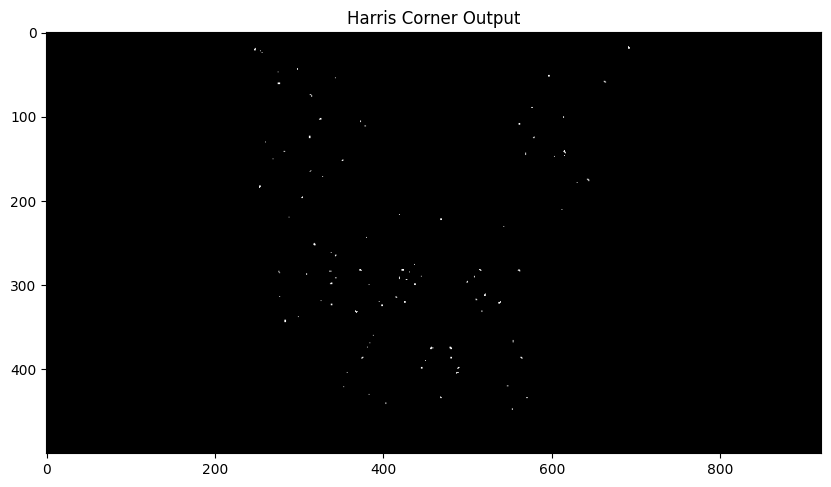

In [100]:
strong_corners = (response > thresh)

plt.figure(figsize=(10,10))
plt.imshow(strong_corners, cmap='gray')
plt.title("Harris Corner Output")
plt.show()

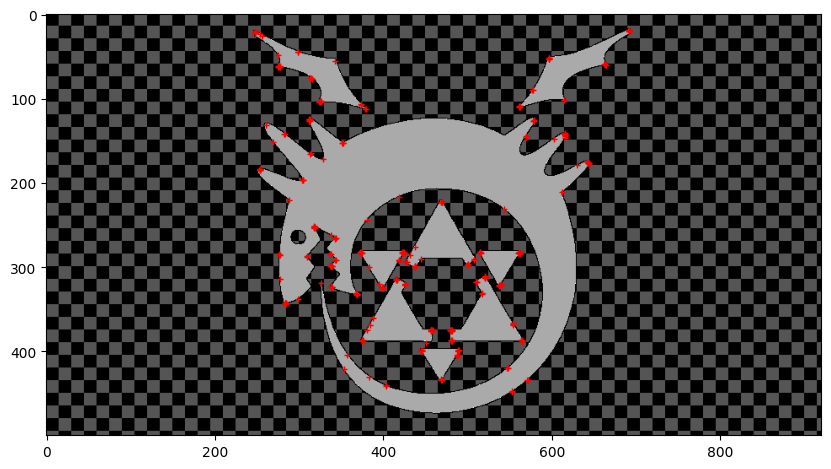

In [101]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(J, cmap=plt.cm.gray)

coords = np.argwhere(strong_corners == 1)
coords.shape

# plot corners
#ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
ax.plot(coords[:, 1], coords[:, 0], '+r', markersize=5, lw=1)
#ax.axis((0, 310, 200, 0))

## USING SCKIT

In [102]:
coords = corner_peaks(corner_harris(J), min_distance=5, threshold_rel=0.02)
coords_subpix = corner_subpix(J, coords, window_size=13)

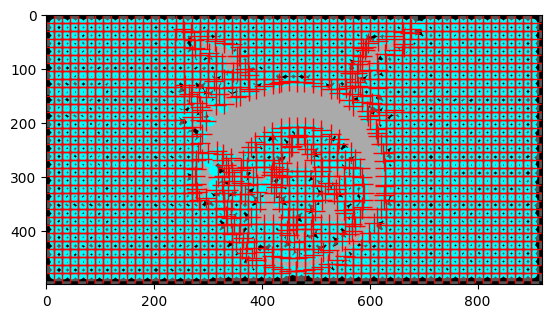

In [103]:
fig, ax = plt.subplots()
ax.imshow(J, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
plt.show()